# Filament Work-Precision Diagrams

DiffEqBenchmarks.jl github: https://github.com/JuliaDiffEq/DiffEqBenchmarks.jl
https://benchmarks.juliadiffeq.org/html/MOLPDE/Filament.html

In this notebook we will benchmark a real-world biological model from a paper entitled Magnetic dipole with a flexible tail as a self-propelling microdevice. This is a system of PDEs representing a Kirchhoff model of an elastic rod, where the equations of motion are given by the Rouse approximation with free boundary conditions.

## Model Implementation
First we will show the full model implementation. It is not necessary to understand the full model specification in order to understand the benchmark results, but it's all contained here for completeness. The model is highly optimized, with all internal vectors pre-cached, loops unrolled for efficiency (along with @simd annotations), a pre-defined Jacobian, matrix multiplications are all in-place, etc. Thus this model is a good stand-in for other optimized PDE solving cases.

The model is thus defined as follows:

In [1]:
using OrdinaryDiffEq, ODEInterfaceDiffEq, Sundials, DiffEqDevTools, LSODA
using LinearAlgebra
using Plots
gr()

Plots.GRBackend()

In [2]:
const T = Float64
abstract type AbstractFilamentCache end
abstract type AbstractMagneticForce end
abstract type AbstractInextensibilityCache end
abstract type AbstractSolver end
abstract type AbstractSolverCache end

In [3]:
struct FerromagneticContinuous <: AbstractMagneticForce
    ω :: T
    F :: Vector{T}
end

mutable struct FilamentCache{
        MagneticForce        <: AbstractMagneticForce,
        InextensibilityCache <: AbstractInextensibilityCache,
        SolverCache          <: AbstractSolverCache
            } <: AbstractFilamentCache
    N  :: Int
    μ  :: T
    Cm :: T
    x  :: SubArray{T,1,Vector{T},Tuple{StepRange{Int,Int}},true}
    y  :: SubArray{T,1,Vector{T},Tuple{StepRange{Int,Int}},true}
    z  :: SubArray{T,1,Vector{T},Tuple{StepRange{Int,Int}},true}
    A  :: Matrix{T}
    P  :: InextensibilityCache
    F  :: MagneticForce
    Sc :: SolverCache
end

In [4]:
struct NoHydroProjectionCache <: AbstractInextensibilityCache
    J         :: Matrix{T}
    P         :: Matrix{T}
    J_JT      :: Matrix{T}
    J_JT_LDLT :: LinearAlgebra.LDLt{T, SymTridiagonal{T}}
    P0        :: Matrix{T}

    NoHydroProjectionCache(N::Int) = new(
        zeros(N, 3*(N+1)),          # J
        zeros(3*(N+1), 3*(N+1)),    # P
        zeros(N,N),                 # J_JT
        LinearAlgebra.LDLt{T,SymTridiagonal{T}}(SymTridiagonal(zeros(N), zeros(N-1))),
        zeros(N, 3*(N+1))
    )
end

In [5]:
struct DiffEqSolverCache <: AbstractSolverCache
    S1 :: Vector{T}
    S2 :: Vector{T}

    DiffEqSolverCache(N::Integer) = new(zeros(T,3*(N+1)), zeros(T,3*(N+1)))
end

In [6]:
function FilamentCache(N=20; Cm=32, ω=200, Solver=SolverDiffEq)
    InextensibilityCache = NoHydroProjectionCache
    SolverCache = DiffEqSolverCache
    tmp = zeros(3*(N+1))
    FilamentCache{FerromagneticContinuous, InextensibilityCache, SolverCache}(
        N, N+1, Cm, view(tmp,1:3:3*(N+1)), view(tmp,2:3:3*(N+1)), view(tmp,3:3:3*(N+1)),
        zeros(3*(N+1), 3*(N+1)), # A
        InextensibilityCache(N), # P
        FerromagneticContinuous(ω, zeros(3*(N+1))),
        SolverCache(N)
    )
end

FilamentCache

In [7]:
function stiffness_matrix!(f::AbstractFilamentCache)
    N, μ, A = f.N, f.μ, f.A
    @inbounds for j in axes(A, 2), i in axes(A, 1)
      A[i, j] = j == i ? 1 : 0
    end
    @inbounds for i in 1 : 3
        A[i,i] =    1
        A[i,3+i] = -2
        A[i,6+i] =  1

        A[3+i,i]   = -2
        A[3+i,3+i] =  5
        A[3+i,6+i] = -4
        A[3+i,9+i] =  1

        A[3*(N-1)+i,3*(N-3)+i] =  1
        A[3*(N-1)+i,3*(N-2)+i] = -4
        A[3*(N-1)+i,3*(N-1)+i] =  5
        A[3*(N-1)+i,3*N+i]     = -2

        A[3*N+i,3*(N-2)+i]     =  1
        A[3*N+i,3*(N-1)+i]     = -2
        A[3*N+i,3*N+i]         =  1

        for j in 2 : N-2
            A[3*j+i,3*j+i]     =  6
            A[3*j+i,3*(j-1)+i] = -4
            A[3*j+i,3*(j+1)+i] = -4
            A[3*j+i,3*(j-2)+i] =  1
            A[3*j+i,3*(j+2)+i] =  1
        end
    end
    rmul!(A, -μ^4)
    nothing
end

stiffness_matrix! (generic function with 1 method)

In [8]:
function update_separate_coordinates!(f::AbstractFilamentCache, r)
    N, x, y, z = f.N, f.x, f.y, f.z
    @inbounds for i in 1 : length(x)
        x[i] = r[3*i-2]
        y[i] = r[3*i-1]
        z[i] = r[3*i]
    end
    nothing
end

update_separate_coordinates! (generic function with 1 method)

In [9]:
function update_united_coordinates!(f::AbstractFilamentCache, r)
    N, x, y, z = f.N, f.x, f.y, f.z
    @inbounds for i in 1 : length(x)
        r[3*i-2] = x[i]
        r[3*i-1] = y[i]
        r[3*i]   = z[i]
    end
    nothing
end

update_united_coordinates! (generic function with 1 method)

In [10]:
function update_united_coordinates(f::AbstractFilamentCache)
    r = zeros(T, 3*length(f.x))
    update_united_coordinates!(f, r)
    r
end

update_united_coordinates (generic function with 1 method)

In [11]:
function initialize!(initial_conf_type::Symbol, f::AbstractFilamentCache)
    N, x, y, z = f.N, f.x, f.y, f.z
    if initial_conf_type == :StraightX
        x .= range(0, stop=1, length=N+1)
        y .= 0
        z .= 0
    else
        error("Unknown initial configuration requested.")
    end
    update_united_coordinates(f)
end

initialize! (generic function with 1 method)

In [12]:
function magnetic_force!(::FerromagneticContinuous, f::AbstractFilamentCache, t)
    # TODO: generalize this for different magnetic fields as well
    N, μ, Cm, ω, F = f.N, f.μ, f.Cm, f.F.ω, f.F.F
    F[1]         = -μ * Cm * cos(ω*t)
    F[2]         = -μ * Cm * sin(ω*t)
    F[3*(N+1)-2] =  μ * Cm * cos(ω*t)
    F[3*(N+1)-1] =  μ * Cm * sin(ω*t)
    nothing
end

magnetic_force! (generic function with 1 method)

In [13]:
struct SolverDiffEq <: AbstractSolver end

function (f::FilamentCache)(dr, r, p, t)
    @views f.x, f.y, f.z = r[1:3:end], r[2:3:end], r[3:3:end]
    jacobian!(f)
    projection!(f)
    magnetic_force!(f.F, f, t)
    A, P, F, S1, S2 = f.A, f.P.P, f.F.F, f.Sc.S1, f.Sc.S2

    # implement dr = P * (A*r + F) in an optimized way to avoid temporaries
    mul!(S1, A, r)
    S1 .+= F
    mul!(S2, P, S1)
    copyto!(dr, S2)
    return dr
end


In [14]:
function jacobian!(f::FilamentCache)
    N, x, y, z, J = f.N, f.x, f.y, f.z, f.P.J
    @inbounds for i in 1 : N
        J[i, 3*i-2]     = -2 * (x[i+1]-x[i])
        J[i, 3*i-1]     = -2 * (y[i+1]-y[i])
        J[i, 3*i]       = -2 * (z[i+1]-z[i])
        J[i, 3*(i+1)-2] =  2 * (x[i+1]-x[i])
        J[i, 3*(i+1)-1] =  2 * (y[i+1]-y[i])
        J[i, 3*(i+1)]   =  2 * (z[i+1]-z[i])
    end
    nothing
end

jacobian! (generic function with 1 method)

In [15]:
function projection!(f::FilamentCache)
    # implement P[:] = I - J'/(J*J')*J in an optimized way to avoid temporaries
    J, P, J_JT, J_JT_LDLT, P0 = f.P.J, f.P.P, f.P.J_JT, f.P.J_JT_LDLT, f.P.P0
    mul!(J_JT, J, J')
    LDLt_inplace!(J_JT_LDLT, J_JT)
    ldiv!(P0, J_JT_LDLT, J)
    mul!(P, P0', J)
    subtract_from_identity!(P)
    nothing
end

projection! (generic function with 1 method)

In [16]:
function subtract_from_identity!(A)
    lmul!(-1, A)
    @inbounds for i in 1 : size(A,1)
        A[i,i] += 1
    end
    nothing
end

subtract_from_identity! (generic function with 1 method)

In [17]:
function LDLt_inplace!(L::LinearAlgebra.LDLt{T,SymTridiagonal{T}}, A::Matrix{T}) where {T<:Real}
    n = size(A,1)
    dv, ev = L.data.dv, L.data.ev
    @inbounds for (i,d) in enumerate(diagind(A))
        dv[i] = A[d]
    end
    @inbounds for (i,d) in enumerate(diagind(A,-1))
        ev[i] = A[d]
    end
    @inbounds @simd for i in 1 : n-1
        ev[i]   /= dv[i]
        dv[i+1] -= abs2(ev[i]) * dv[i]
    end
    L
end

LDLt_inplace! (generic function with 1 method)

# Investigating the model

In [19]:
function run(::SolverDiffEq; N=20, Cm=32, ω=200, time_end=1., solver=TRBDF2(autodiff=false), reltol=1e-6, abstol=1e-6)
    f = FilamentCache(N, Solver=SolverDiffEq, Cm=Cm, ω=ω)
    r0 = initialize!(:StraightX, f)
    stiffness_matrix!(f)
    prob = ODEProblem(ODEFunction(f, jac=(J, u, p, t)->(mul!(J, f.P.P, f.A); nothing)), r0, (0., time_end))
    sol = solve(prob, solver, dense=false, reltol=reltol, abstol=abstol)
end

run (generic function with 1 method)

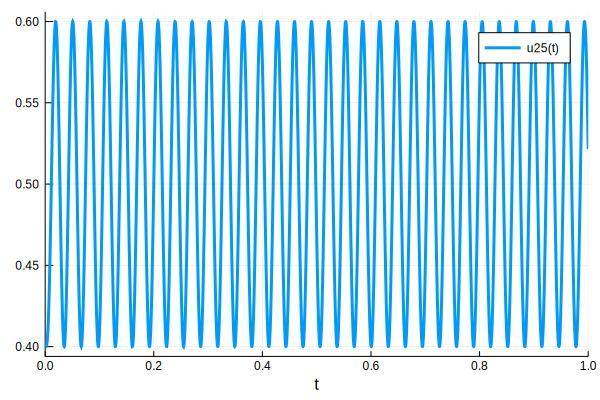

In [20]:
sol = run(SolverDiffEq())
plot(sol,vars = (0,25))

The model quickly falls into a highly oscillatory mode which then dominates throughout the rest of the solution.

# Work-Precision Diagrams

Now let's build the problem and solve it once at high accuracy to get a reference solution:

In [23]:
N=20
f = FilamentCache(N, Solver=SolverDiffEq)
r0 = initialize!(:StraightX, f)
stiffness_matrix!(f)
prob = ODEProblem(f, r0, (0., 0.01))

sol = solve(prob, Vern9(), reltol=1e-14, abstol=1e-14)
test_sol = TestSolution(sol)

retcode: Success
Interpolation: specialized 9th order lazy interpolation
t: nothing
u: nothing

# Omissions

In [24]:
# abstols=1 ./10 .^(3:8)
# reltols=1 ./10 .^(3:8)
# setups = [
#     Dict(:alg => CVODE_BDF()),
#     Dict(:alg => Rosenbrock23(autodiff=false)),
#     Dict(:alg => Rodas4(autodiff=false)),
#     Dict(:alg => radau()),
#     Dict(:alg=>Exprb43(autodiff=false)),
#     Dict(:alg=>Exprb32(autodiff=false)),
#     Dict(:alg=>ImplicitEulerExtrapolation(autodiff=false)),
#     Dict(:alg=>ImplicitDeuflhardExtrapolation(autodiff=false)),
#     Dict(:alg=>ImplicitHairerWannerExtrapolation(autodiff=false)),
#     ];

# wp = WorkPrecisionSet(prob, abstols, reltols, setups; appxsol=test_sol,
#                       maxiters=Int(1e6), verbose = false)
# plot(wp)

┌ Warning: Threading in `ImplicitEulerExtrapolation` is currently disabled. Thus `threading` has been changed from `true` to `false`.
└ @ OrdinaryDiffEq /home/seneryilmaz/.julia/packages/OrdinaryDiffEq/9RyJb/src/algorithms.jl:64


InterruptException: InterruptException:

Rosenbrock23, Rodas4, Exprb32, Exprb43, extrapolation methods, and Rodas5 do not perform well at all and are thus dropped from future tests. For reference, they are in the 10^(2.5) range in for their most accurate run (with ImplicitEulerExtrapolation takes over a day to run, and had to be prematurely stopped), so about 500x slower than CVODE_BDF and thus make the benchmarks take forever. It looks like radau fails on this problem with high tolerance so its values should be ignored since it exits early. It is thus removed from the next sections.

The EPIRK methods currently do not work on this problem

In [25]:
# sol = solve(prob, EPIRK4s3B(autodiff=false), dt=2^-3)

but would be called like:

In [26]:
# abstols=1 ./10 .^(3:5)
# reltols=1 ./10 .^(3:5)
# setups = [
#     Dict(:alg => CVODE_BDF()),
#     Dict(:alg => HochOst4(),:dts=>2.0.^(-3:-1:-5)),
#     Dict(:alg => EPIRK4s3B(),:dts=>2.0.^(-3:-1:-5)),
#     Dict(:alg => EXPRB53s3(),:dts=>2.0.^(-3:-1:-5)),
#     ];

# wp = WorkPrecisionSet(prob, abstols, reltols, setups; appxsol=test_sol,
#                       maxiters=Int(1e6), verbose = false)
# plot(wp)

# High Tolerance (Low Accuracy)

## Endpoint Error

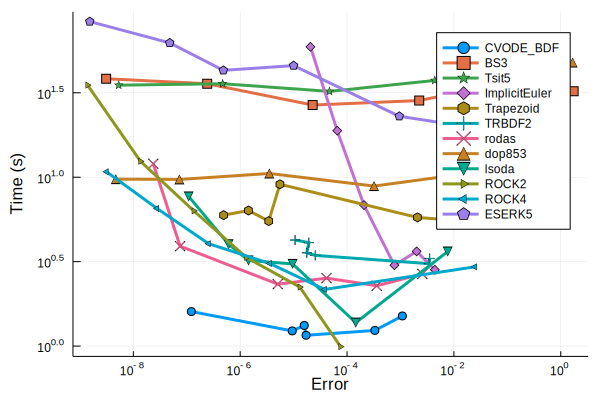

In [27]:
abstols=1 ./10 .^(3:8)
reltols=1 ./10 .^(3:8)
setups = [
    Dict(:alg => CVODE_BDF()),
    Dict(:alg => BS3()),
    Dict(:alg => Tsit5()),
    Dict(:alg => ImplicitEuler(autodiff=false)),
    Dict(:alg => Trapezoid(autodiff=false)),
    Dict(:alg => TRBDF2(autodiff=false)),
    Dict(:alg => rodas()),
    Dict(:alg => dop853()),
    Dict(:alg => lsoda()),
    Dict(:alg => ROCK2()),
    Dict(:alg => ROCK4()),
    Dict(:alg => ESERK5())
    ];

wp = WorkPrecisionSet(prob, abstols, reltols, setups; appxsol=test_sol,
                      maxiters=Int(1e6), verbose = false)
plot(wp)

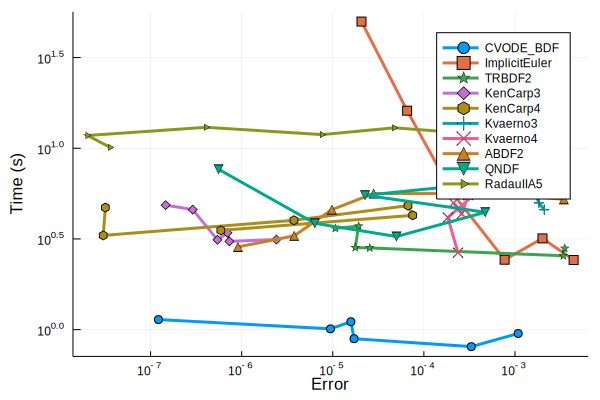

In [28]:
abstols=1 ./10 .^(3:8)
reltols=1 ./10 .^(3:8)
setups = [
    Dict(:alg => CVODE_BDF()),
    Dict(:alg => ImplicitEuler(autodiff=false)),
    Dict(:alg => TRBDF2(autodiff=false)),
    Dict(:alg => KenCarp3(autodiff=false)),
    Dict(:alg => KenCarp4(autodiff=false)),
    Dict(:alg => Kvaerno3(autodiff=false)),
    Dict(:alg => Kvaerno4(autodiff=false)),
    Dict(:alg => ABDF2(autodiff=false)),
    Dict(:alg => QNDF(autodiff=false)),
    Dict(:alg => RadauIIA5(autodiff=false)),
];

wp = WorkPrecisionSet(prob, abstols, reltols, setups; appxsol=test_sol,
                      maxiters=Int(1e6), verbose = false)
plot(wp)

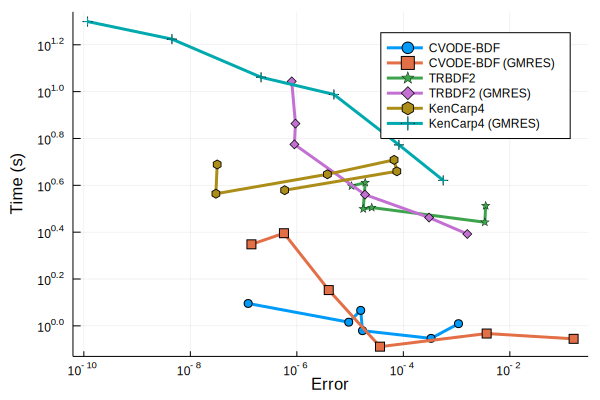

In [29]:
abstols=1 ./10 .^(3:8)
reltols=1 ./10 .^(3:8)
setups = [
    Dict(:alg => CVODE_BDF()),
    Dict(:alg => CVODE_BDF(linear_solver=:GMRES)),
    Dict(:alg => TRBDF2(autodiff=false)),
    Dict(:alg => TRBDF2(autodiff=false,linsolve=LinSolveGMRES())),
    Dict(:alg => KenCarp4(autodiff=false)),
    Dict(:alg => KenCarp4(autodiff=false,linsolve=LinSolveGMRES())),
];

names = [
    "CVODE-BDF",
    "CVODE-BDF (GMRES)",
    "TRBDF2",
    "TRBDF2 (GMRES)",
    "KenCarp4",
    "KenCarp4 (GMRES)",
];

wp = WorkPrecisionSet(prob, abstols, reltols, setups; names=names, appxsol=test_sol,
                      maxiters=Int(1e6), verbose = false)
plot(wp)

# Timeseries Error

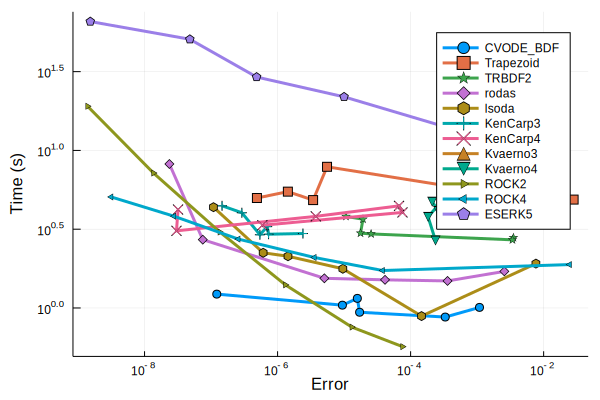

In [30]:
abstols=1 ./10 .^(3:8)
reltols=1 ./10 .^(3:8)
setups = [
    Dict(:alg => CVODE_BDF()),
    Dict(:alg => Trapezoid(autodiff=false)),
    Dict(:alg => TRBDF2(autodiff=false)),
    Dict(:alg => rodas()),
    Dict(:alg => lsoda()),
    Dict(:alg => KenCarp3(autodiff=false)),
    Dict(:alg => KenCarp4(autodiff=false)),
    Dict(:alg => Kvaerno3(autodiff=false)),
    Dict(:alg => Kvaerno4(autodiff=false)),
    Dict(:alg => ROCK2()),
    Dict(:alg => ROCK4()),
    Dict(:alg => ESERK5())
];

wp = WorkPrecisionSet(prob, abstols, reltols, setups; appxsol=test_sol,
                      maxiters=Int(1e6), verbose = false)
plot(wp)

Timeseries errors seem to match final point errors very closely in this problem, so these are turned off in future benchmarks.

(Confirmed in the other cases)

# Dense Error

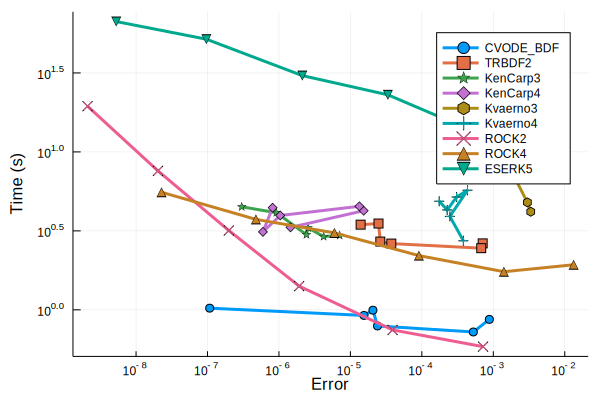

In [31]:
abstols=1 ./10 .^(3:8)
reltols=1 ./10 .^(3:8)
setups = [
    Dict(:alg => CVODE_BDF()),
    Dict(:alg => TRBDF2(autodiff=false)),
    Dict(:alg => KenCarp3(autodiff=false)),
    Dict(:alg => KenCarp4(autodiff=false)),
    Dict(:alg => Kvaerno3(autodiff=false)),
    Dict(:alg => Kvaerno4(autodiff=false)),
    Dict(:alg => ROCK2()),
    Dict(:alg => ROCK4()),
    Dict(:alg => ESERK5())
];

wp = WorkPrecisionSet(prob, abstols, reltols, setups; appxsol=test_sol,
                      maxiters=Int(1e6), verbose = false, dense_errors = true, error_estimate=:L2)
plot(wp)